In [407]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics as metrics

In [408]:
data: pd.DataFrame = pd.read_csv("elden_ring_steam_reviews.csv")
data

,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,134238864,english,being killed over and over again is fun,2023-03-07 14:19:11,True,0,0,False,False,False,47,2,355,355,346,2023-03-07 14:29:21
1,134238208,english,I write this review as I have 100% completed E...,2023-03-07 14:03:24,True,0,0,True,False,False,110,2,24238,5823,24238,2023-03-07 02:08:22
2,134238033,english,Fun,2023-03-07 13:59:13,True,0,0,True,False,False,11,1,912,912,881,2023-03-07 14:30:07
3,134237508,english,pretty cool.,2023-03-07 13:46:37,True,0,0,True,False,False,94,8,8497,2914,8497,2023-03-07 13:44:52
4,134236511,english,AMAZINGGGGGGGGGGGGG,2023-03-07 13:20:04,True,0,0,True,False,False,4,1,985,163,923,2023-03-07 14:26:41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9789,131803069,english,Best platformer of the year.,2023-01-29 14:50:25,True,0,0,True,False,False,112,8,12095,1751,7565,2023-03-06 13:54:32
9790,131802918,english,"truly fun...very recommended, worth the money ...",2023-01-29 14:47:55,True,0,0,True,False,False,17,4,9467,39,8394,2023-02-26 17:51:52
9791,131802717,english,mimic is the friend we made along the way,2023-01-29 14:44:41,True,0,0,True,False,False,34,3,8098,6,5655,2023-02-23 10:17:41
9792,131802309,english,"The lands of Elden Ring are vast and wild, fil...",2023-01-29 14:38:38,True,1,0,True,False,False,70,8,9472,201,9191,2023-03-05 13:39:17


In [409]:
from sklearn.calibration import LabelEncoder
import sklearn.preprocessing as preprocessing


encoder = preprocessing.LabelEncoder()
data["review"].fillna("empty", inplace=True)
for column in data.columns:
    if data[column].dtype == 'object':
    # Примените кодирование только к колонкам с типом 'object' (строки)
        data[column] = encoder.fit_transform(data[column])

del data["id"]
del data["steam_purchase"]
del data["language"]
del data["written_during_early_access"]

In [410]:
def transformator(x): 
    if x >= 100 * 60: return "Main+Sides"
    elif x >= 58 * 60: return "MainStory" 
    return "NotCompleted"

data["author_completed_100"] = data["author_playtime_at_review"].apply(transformator, True).to_frame()

C:\Users\Farukh\AppData\Local\Temp\ipykernel_516\3819600759.py:6: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.



<Axes: xlabel='author_completed_100'>

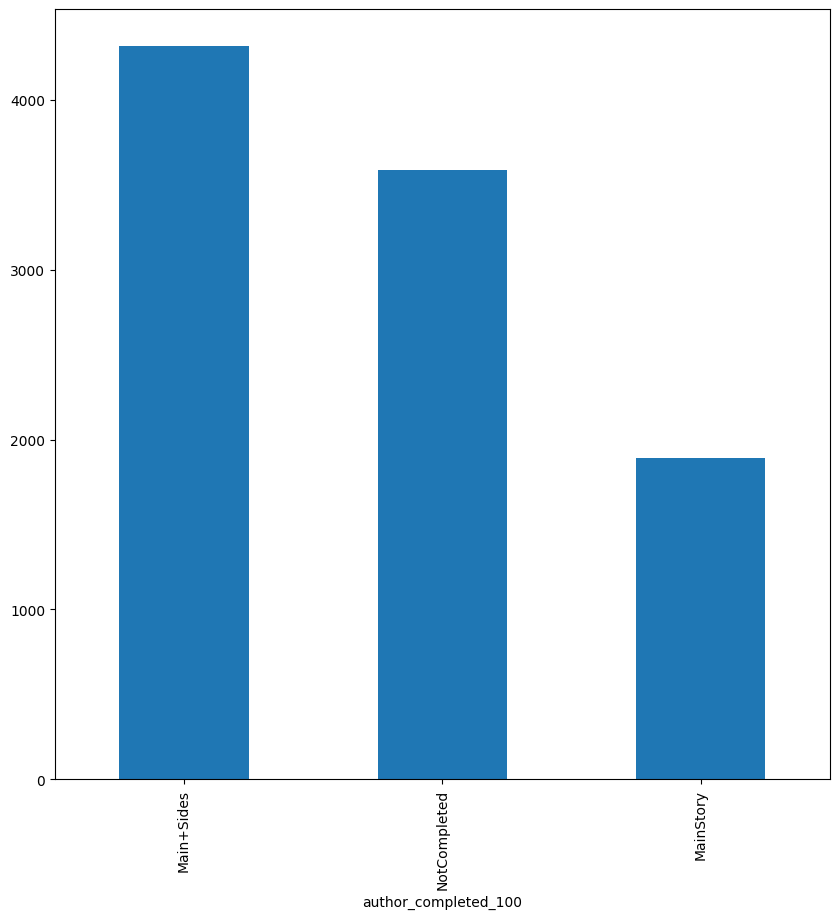

In [411]:
ser = data["author_completed_100"].value_counts()
ser.plot.bar()

In [412]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data["author_playtime_at_review"], data["author_completed_100"], train_size=0.8, shuffle=True, random_state=271)
x_train = x_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)
print(f"x_train {x_train.shape}, y_train {y_train.shape}")
print(f"x_test {x_test.shape}, y_test {y_test.shape}")

x_train (7835, 1), y_train (7835,)
x_test (1959, 1), y_test (1959,)


In [413]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=271)
model_lr.fit(x_train, y_train)
y_predict = model_lr.predict(x_test)
print("Предсказанные значения", y_predict)
print("Исходные значения", np.array(y_test))

Предсказанные значения ['Main+Sides' 'Main+Sides' 'Main+Sides' ... 'Main+Sides' 'Main+Sides'
 'Main+Sides']
Исходные значения ['Main+Sides' 'NotCompleted' 'NotCompleted' ... 'NotCompleted' 'MainStory'
 'MainStory']


In [414]:
import plotly.express as px

def build_matrix(y_test, y_predict):
    matrix_data = metrics.confusion_matrix(y_test, y_predict)
    print(matrix_data)
    plt.rcParams['figure.figsize'] = (10, 10)
    fig = px.imshow(matrix_data, text_auto=True)
    return fig.update_layout(xaxis_title = "Target", yaxis_title = "Predicted")

build_matrix(y_test, y_predict)

[[823   0   0]
 [384   0   0]
 [752   0   0]]


In [415]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [416]:
param_kernel = ('linear', 'rbf', 'poly', 'sigmoid')
parameters = {'kernel': param_kernel}
model_svc = SVC()
grid_search_svm = GridSearchCV(estimator=model_svc, param_grid=parameters, cv=6)
grid_search_svm.fit(x_train, y_train)
model_svm = grid_search_svm.best_estimator_


In [ ]:
model_svm.kernel

'linear'

In [ ]:
svm_preds = model_svm.predict(x_test)
build_matrix(y_test, svm_preds)

[[823   0   0]
 [  0 384   0]
 [  0   0 752]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neighbors_num = range(3, 10)
model_KNN = KNeighborsClassifier()
params = {'n_neighbors': neighbors_num}

grid_search_knn = GridSearchCV(estimator=model_KNN, param_grid=params, cv=6)
grid_search_knn.fit(x_train, y_train)

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 10)})

In [ ]:
grid_search_svm.best_score_

0.9998723838693211

In [ ]:
grid_search_knn.best_estimator_

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_preds = grid_search_knn.predict(x_test)
build_matrix(y_test, knn_preds)

[[823   0   0]
 [  0 384   0]
 [  0   0 752]]


In [ ]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

  Main+Sides       1.00      1.00      1.00       823
   MainStory       1.00      1.00      1.00       384
NotCompleted       1.00      1.00      1.00       752

    accuracy                           1.00      1959
   macro avg       1.00      1.00      1.00      1959
weighted avg       1.00      1.00      1.00      1959



In [ ]:
print(metrics.classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

  Main+Sides       1.00      1.00      1.00       823
   MainStory       1.00      1.00      1.00       384
NotCompleted       1.00      1.00      1.00       752

    accuracy                           1.00      1959
   macro avg       1.00      1.00      1.00      1959
weighted avg       1.00      1.00      1.00      1959



In [ ]:
print(metrics.classification_report(y_test, knn_preds))

              precision    recall  f1-score   support

  Main+Sides       1.00      1.00      1.00       823
   MainStory       1.00      1.00      1.00       384
NotCompleted       1.00      1.00      1.00       752

    accuracy                           1.00      1959
   macro avg       1.00      1.00      1.00      1959
weighted avg       1.00      1.00      1.00      1959

